In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
from itertools import combinations
from collections import Counter
from zipfile import ZipFile
import os
from networkx.algorithms.community import girvan_newman
import json
import requests
import re
import matplotlib.patches as mpatches
import itertools
import matplotlib.cm as cm
from pprint import pprint
import math
import pyLDAvis.gensim
import pickle 
import pyLDAvis
from tqdm import tqdm
import gensim
from gensim import corpora
from wordcloud import WordCloud
import community.community_louvain as cl
import community
from sklearn.cluster import SpectralClustering
# from fa2 import ForceAtlas2
import community as community_louvain
import matplotlib.colors as mcolors
import colorsys
from scipy.spatial import distance

# nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
pd.options.mode.chained_assignment = None  # default='warn'

/opt/anaconda3/lib/python3.9/site-packages/botocore/httpsession.py:41: DeprecationWarning: 'urllib3.contrib.pyopenssl' module is deprecated and will be removed in a future release of urllib3 2.x. Read more in this issue: https://github.com/urllib3/urllib3/issues/2680
  from urllib3.contrib.pyopenssl import orig_util_SSLContext as SSLContext
/opt/anaconda3/lib/python3.9/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
[nltk_data] Downloading package wordnet to /Users/ellen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ellen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Reusable variables
seed = 33
d_color = "#4152ec"
colors = ['#292929', '#768695', d_color, '#50dcff', '#ffa30e', '#ffe72f', '#f43131', '#ff9ad2', '#2ca02c', '#a8ee72', '#795133', '#c98d66']

In [3]:
# used csv files, linking it with their source zip files
csv_to_zip_source = {
    "Netflix_Dataset_Movie.csv": "zip_sources/Netflix_Dataset_Movie.csv.zip",
    "Netflix_Dataset_Rating.csv": "zip_sources/Netflix_Dataset_Rating.csv.zip",
    "tmdb_5000_credits.csv": "zip_sources/tmdb.zip",
    "tmdb_5000_movies.csv": "zip_sources/tmdb.zip"
}

csv_file_names = list(csv_to_zip_source.keys())

# common data directory path
data_dir = "./data"

# if directory does not exist, create it
if not os.path.isdir(data_dir):
    os.mkdir(data_dir)

# check if all .csv can be found in data directory, if not we extract it from corresponding zip source
for csv_file_name in csv_file_names:
    if not os.path.exists(f"{data_dir}/{csv_file_name}"):
        # if it is not found
        zip_source_file_name = csv_to_zip_source[csv_file_name]
        print(f"❗'{csv_file_name}' does not exist in the '{data_dir}' directory, extracting it from zip file '{zip_source_file_name}'...")
        with ZipFile(zip_source_file_name, 'r') as zip:
            zip.extract(csv_file_name, path=data_dir)
            print(f"Done extracting {csv_file_name} from {zip_source_file_name}")
    else:
        # csv exists and found, let user know
        print(f"'{data_dir}/{csv_file_name}' exists ✅")
    print("---")

'./data/Netflix_Dataset_Movie.csv' exists ✅
---
'./data/Netflix_Dataset_Rating.csv' exists ✅
---
'./data/tmdb_5000_credits.csv' exists ✅
---
'./data/tmdb_5000_movies.csv' exists ✅
---


In [4]:
movies = pd.read_csv(f"{data_dir}/Netflix_Dataset_Movie.csv")
ratings = pd.read_csv(f"{data_dir}/Netflix_Dataset_Rating.csv")
credits = pd.read_csv(f"{data_dir}/tmdb_5000_credits.csv")
tmdb_movies = pd.read_csv(f"{data_dir}/tmdb_5000_movies.csv")

In [5]:
movies_subset = movies[movies.Year >= 2000]
df_movies_subset = movies_subset[movies_subset.Name.isin(credits.title)] #movies that are in credits
df_tmdb = tmdb_movies[tmdb_movies.title.isin(df_movies_subset.Name)]#movies that are also in the other movie data set

In [6]:
#check missing data
print("Number of movies without listed genres:", len(df_tmdb[df_tmdb.genres == '[]']))
print("Number of movies without listed keywords:", len(df_tmdb[df_tmdb.keywords == '[]']))
print("Number of movies without listed overview", len(df_tmdb[df_tmdb.overview == '']))
print("Number of movies with NaN as overview:", len(df_tmdb.overview[df_tmdb.overview.isnull()]))
print("Number of movies with NaN as tagline:", len(df_tmdb.tagline[df_tmdb.tagline.isnull()]))

Number of movies without listed genres: 1
Number of movies without listed keywords: 66
Number of movies without listed overview 0
Number of movies with NaN as overview: 0
Number of movies with NaN as tagline: 149


In [7]:
#remove movies, where there are either/or not genres, keywords or tagline
df_tmdb = df_tmdb[df_tmdb.genres != '[]']
df_tmdb = df_tmdb[df_tmdb.keywords != '[]']
df_tmdb = df_tmdb[df_tmdb.tagline.notnull()].reset_index()

In [8]:
#check if there are movies left in the data with missing values
print("Number of movies without listed genres:", len(df_tmdb[df_tmdb.genres == '[]']))
print("Number of movies without listed keywords:", len(df_tmdb[df_tmdb.keywords == '[]']))
print("Number of movies without listed overview", len(df_tmdb[df_tmdb.overview == '']))
print("Number of movies with NaN as overview:", len(df_tmdb.overview[df_tmdb.overview.isnull()]))
print("Number of movies with NaN as tagline:", len(df_tmdb.tagline[df_tmdb.tagline.isnull()]))

Number of movies without listed genres: 0
Number of movies without listed keywords: 0
Number of movies without listed overview 0
Number of movies with NaN as overview: 0
Number of movies with NaN as tagline: 0


In [9]:
#remove movies not in df_tmdb(after some were removed)
df_movies = movies_subset[movies_subset.Name.isin(df_tmdb.title)]
df_credits = credits[credits.title.isin(df_tmdb.title)]
df_ratings = ratings[ratings.Movie_ID.isin(df_movies.Movie_ID)]

In [412]:
#save df_ratings as pickle
df_ratings.to_pickle("ratings.pkl")  

In [10]:
#convert from string to list
df_tmdb['genres'] = df_tmdb['genres'].apply(json.loads)
df_tmdb['keywords'] = df_tmdb['keywords'].apply(json.loads)

In [11]:
def convertJSON(df, column): #column as string
    columnDict = {}
    for i in range(0,len(df)): #loop through index
        columnList = []
        for j in range(0, len(df[column][i])): #loop through column for that row
            columnList.append(df[column][i][j]['name'])
        columnDict[i] = ', '.join(columnList)
        
    return columnDict

In [12]:
#convert from json 
genreDict = convertJSON(df_tmdb, 'genres')
keywordsDict = convertJSON(df_tmdb, 'keywords')

df_tmdb['genres'] = genreDict.values()
df_tmdb['keywords'] = keywordsDict.values()

---
# **Find preferred genre**
---

In [202]:
def filterByGenre(movieTitle, df): #find movies with at least one of the same genres as the movie just seen
    genres = df[df.title == movieTitle].genres.str.replace(' ', '|').iloc[0] ##replace , by |. This is the genres to look for in 
    genreMovies = df[df.genres.str.contains(genres)] #find movies with at least one of the genres
    
    return genreMovies

---
# **Movie network**
---
- **Nodes**: Movies
- **Edges**: Two movies are connected if they have a common actor in their top 5 staring actors.

## **Network**

In [14]:
G_movies = nx.Graph()

# Iterate over each row in the credits dataframe
for index, row in df_credits.iterrows():
    cast = json.loads(row['cast']) # Parse the cast column (=JSON string)
    
    # Get names of the first 10 actors
    actors = [actor['name'] for actor in cast[:3]]
    G_movies.add_node(row['title'], actors=actors)

# Iterate over all pairs of movies
for movie1, movie2 in combinations(G_movies.nodes, 2):
    # Actors for each movie
    actors1 = G_movies.nodes[movie1]['actors']
    actors2 = G_movies.nodes[movie2]['actors']
    
    # Number of common actors
    common_actors = len(set(actors1) & set(actors2))
    
    # If they have at least x common actors, add an edge between them
    if common_actors >= 1:
        G_movies.add_edge(movie1, movie2)


In [15]:
# Largest connected component
largest_cc = max(nx.connected_components(G_movies), key=len)
G_movies_lcc = G_movies.subgraph(largest_cc)

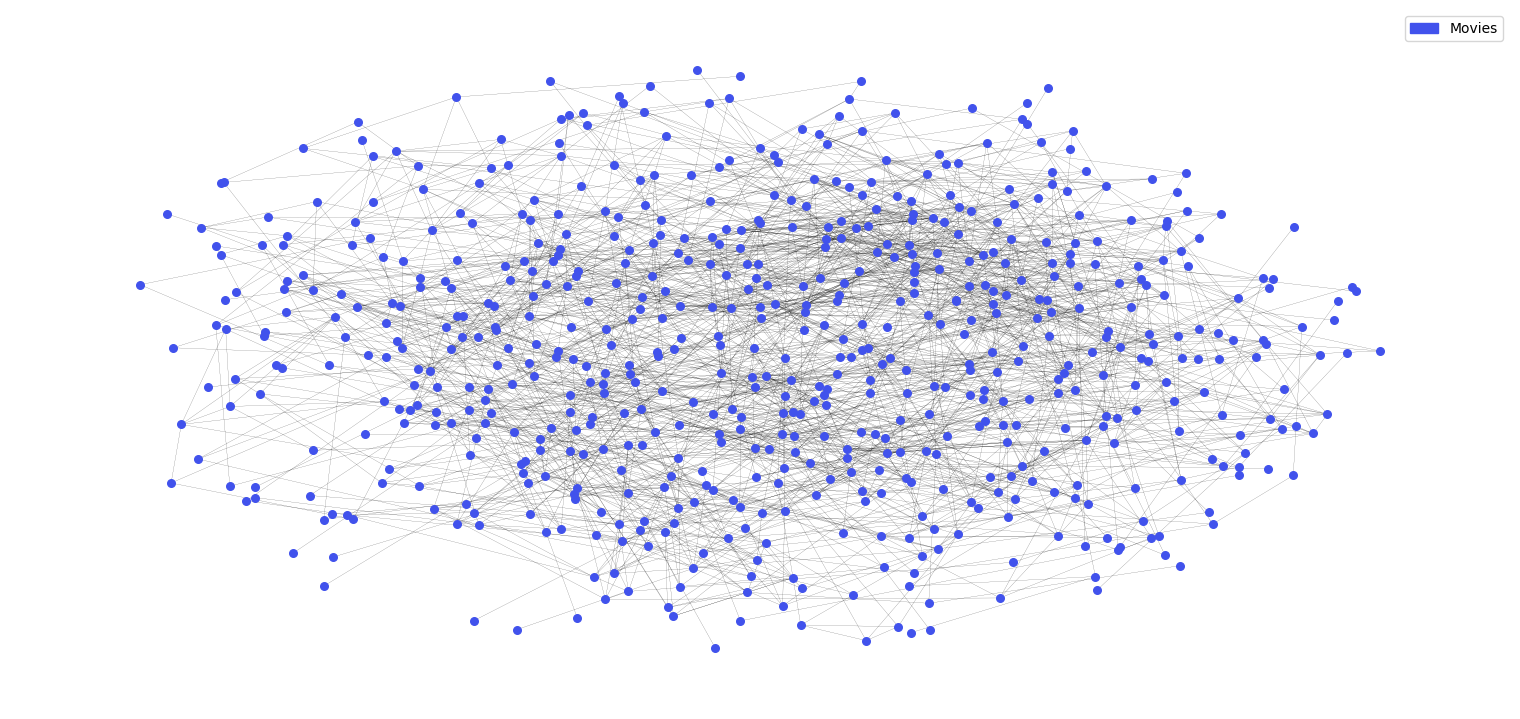

In [16]:
# Layout
plt.figure(figsize=(15, 7))
# pos = nx.spring_layout(G_movies_lcc)
pos = nx.spring_layout(G_movies_lcc, k=0.3)

# Draw network
nx.draw(G_movies_lcc, pos, node_color=d_color, edge_color='black', with_labels=False, node_size=30, width=0.1)

# Legend
movies_patch = mpatches.Patch(color=d_color, label='Movies')
plt.legend(handles=[movies_patch])
plt.show()

In [17]:
n_nodes = len(G_movies_lcc.nodes())
n_edges = len(G_movies_lcc.edges())
print("Number of nodes:", n_nodes)
print("Number of edges:", n_edges)

Number of nodes: 644
Number of edges: 2093


## **Communities**

In [18]:
# Girvan–Newman algorithm
nx_communities = nx.algorithms.centrality.edge_betweenness_centrality(G_movies_lcc)
nx_girvan_newman = nx.algorithms.community.centrality.girvan_newman(G_movies_lcc)
nx_best_community = tuple(sorted(c) for c in next(nx_girvan_newman))
num_communities = len(nx_best_community)
nx_modularity_G = nx.algorithms.community.quality.modularity(G_movies_lcc, nx_best_community)

print("Girvan–Newman:")
print("\t- Number of communities found by Girvan-Newman:", num_communities)
print("\t- Modularity:", round(nx_modularity_G,2))

Girvan–Newman:
	- Number of communities found by Girvan-Newman: 2
	- Modularity: 0.01


In [19]:
# Louvain algorithm
communities_Louvain = cl.best_partition(G_movies_lcc, random_state=seed)
n_communities_Louvain = len(np.unique(list(communities_Louvain.values())))
modularity_Louvain = community.modularity(communities_Louvain, G_movies_lcc)

print("Louvain:")
print("\t- Number of communities found by Louvain:", n_communities_Louvain)
print("\t- Modularity:", round(modularity_Louvain,2))

Louvain:
	- Number of communities found by Louvain: 17
	- Modularity: 0.65


In [20]:
# Spectral clustering - Choosing random number of clusters
np.random.seed(seed)

adj_mat = nx.to_numpy_array(G_movies_lcc)
sc = SpectralClustering(52, affinity='precomputed', n_init=100)
sc.fit(adj_mat)
nodes = list(G_movies_lcc.nodes())
communities_Spectral = communities_Spectral = [set(nodes[i] for i in np.where(sc.labels_ == j)[0]) for j in range(sc.n_clusters)]
n_communities_Spectral = len(communities_Spectral) 
modularity_Spectral = nx.algorithms.community.quality.modularity(G_movies_lcc, communities_Spectral)

print("Spectral clustering:")
print("\t- Number of communities found with spectral clustering:", n_communities_Spectral)
print("\t- Modularity:", round(modularity_Spectral,2))

Spectral clustering:
	- Number of communities found with spectral clustering: 52
	- Modularity: 0.58


In [21]:
# Spectral clustering - Finding the best number of clusters 
np.random.seed(seed)

adj_mat = nx.to_numpy_array(G_movies_lcc)
nodes = list(G_movies_lcc.nodes())

best_modularity = -np.inf
best_n_clusters = None
best_communities = None

# Try different numbers of clusters
for n_clusters in range(2, 100):
    sc = SpectralClustering(n_clusters, affinity='precomputed', n_init=100)
    sc.fit(adj_mat)

    # Convert labels array to list of sets format
    communities = [set(nodes[i] for i in np.where(sc.labels_ == j)[0]) for j in range(n_clusters)]
    modularity = nx.algorithms.community.quality.modularity(G_movies_lcc, communities)

    # Update
    if modularity > best_modularity:
        best_modularity = modularity
        best_n_clusters = n_clusters
        best_communities = communities

print("Best modularity is", best_modularity, "found with", best_n_clusters, "clusters.")
# Approx 3:33 min to run

Best modularity is 0.590931275251681 found with 56 clusters.


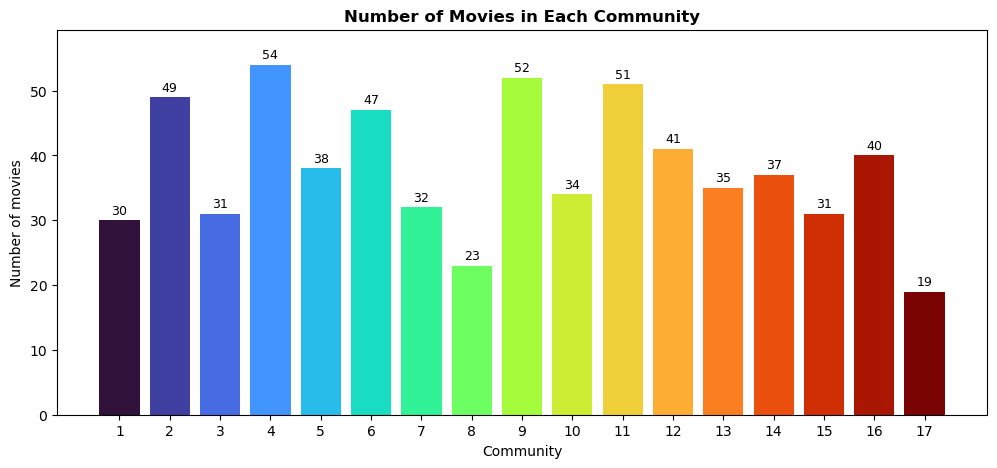

In [22]:
# Number of movies in each community
communities_Louvain_list = [set() for _ in range(n_communities_Louvain)]
for node, community_id in communities_Louvain.items():
    communities_Louvain_list[community_id].add(node)

num_movies = [len(community) for community in communities_Louvain_list]

# Colors
cmap = plt.cm.get_cmap("turbo", n_communities_Louvain)


# Histogram
plt.figure(figsize=(12, 5))
bars = plt.bar(range(1, n_communities_Louvain + 1), num_movies, color=cmap(range(n_communities_Louvain)))
# bars = plt.bar(range(1, n_communities_Louvain + 1), num_movies, color=[colors[i % len(colors)] for i in range(n_communities_Louvain)])
plt.xticks(range(1, n_communities_Louvain + 1))
plt.ylim(0, max(num_movies) + (max(num_movies)/10))
plt.xlabel("Community")
plt.ylabel("Number of movies")
plt.title("Number of Movies in Each Community", fontweight="bold")

# Add the precise number of movies above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha="center", va="bottom", fontsize=9)

plt.show()

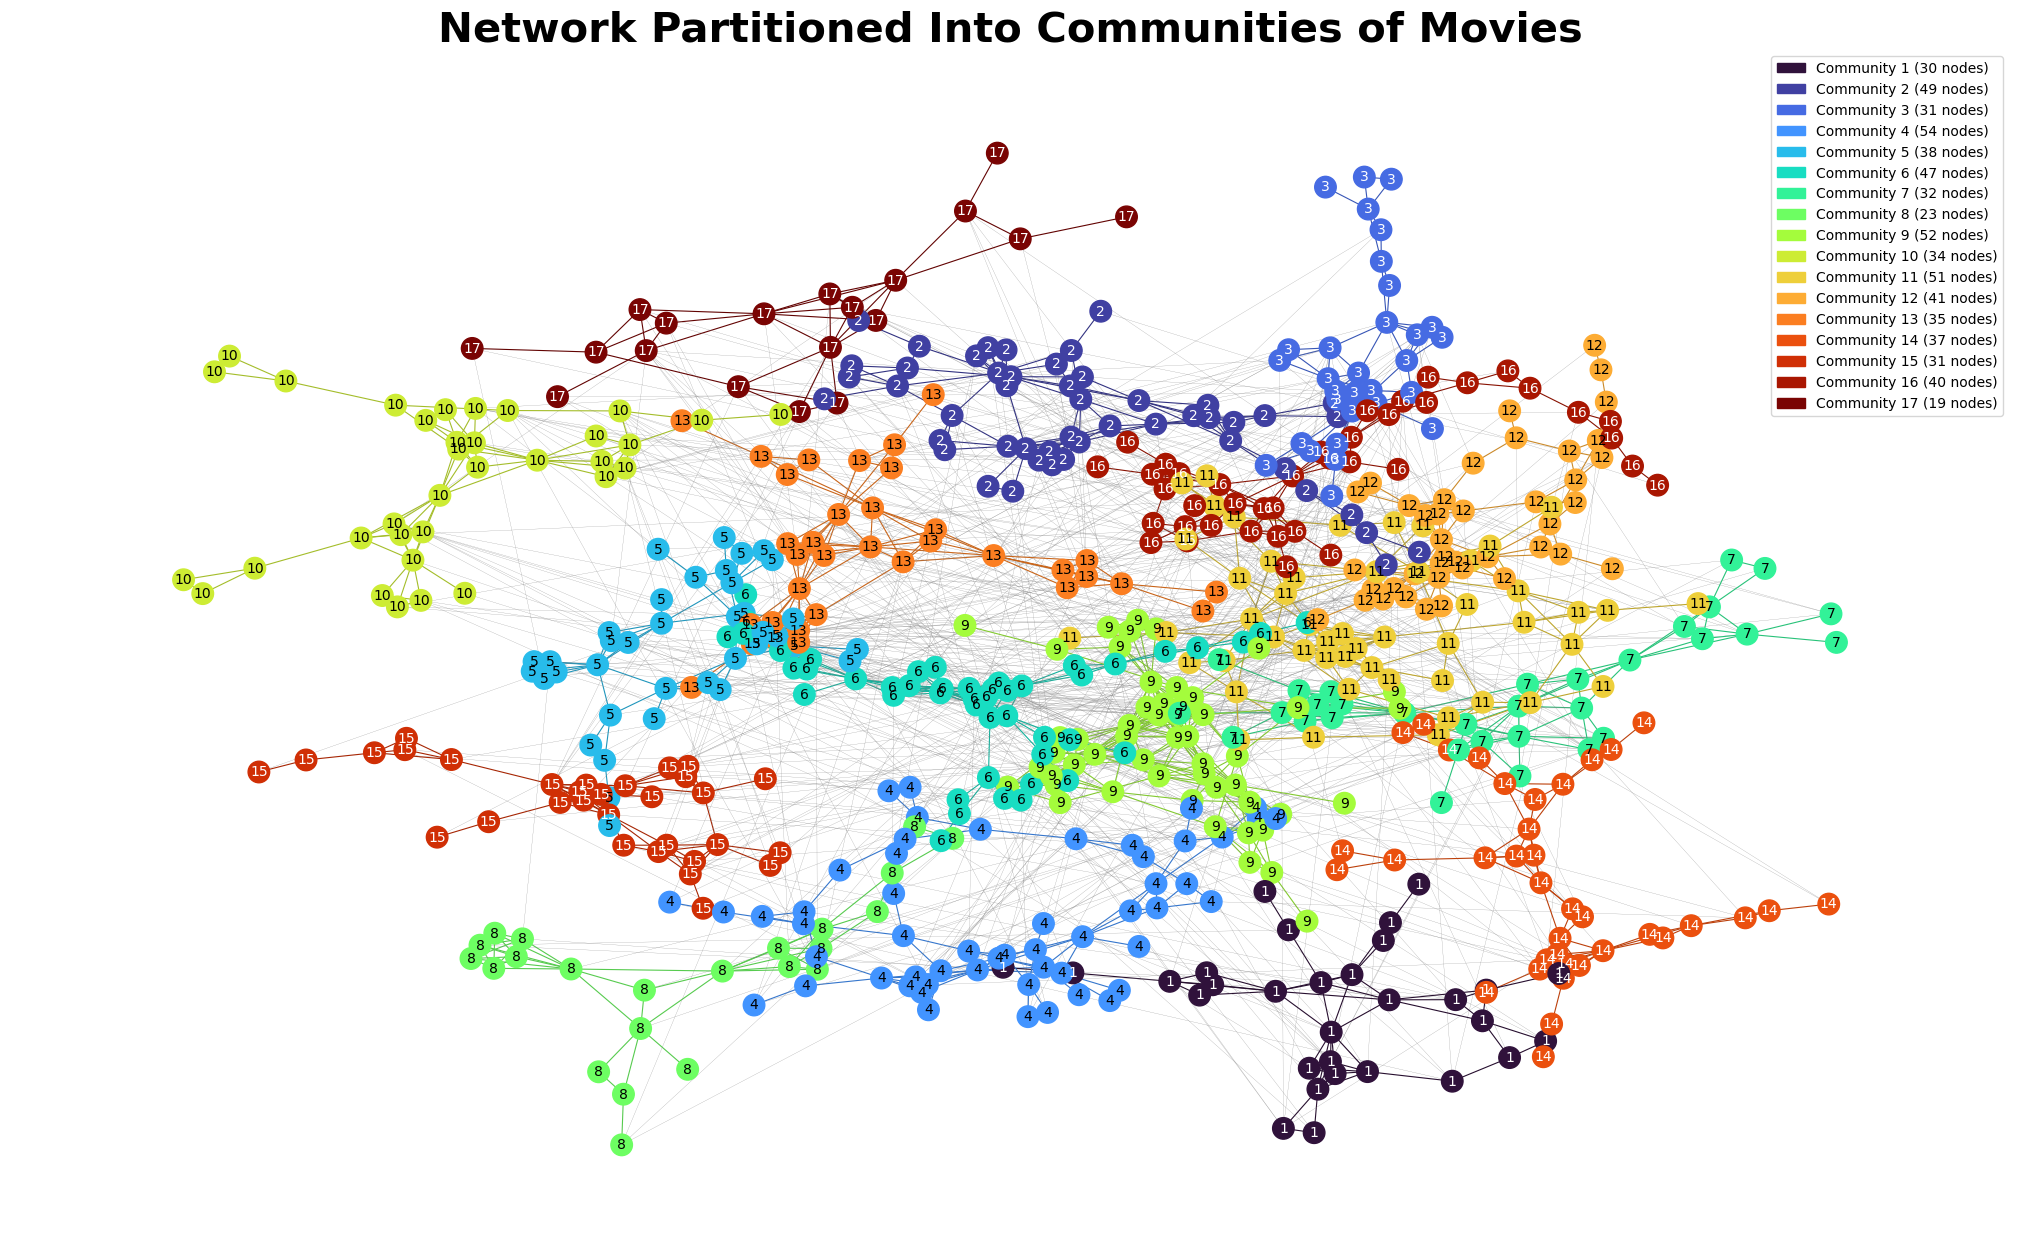

In [23]:
cmap = plt.cm.get_cmap("turbo", len(communities_Louvain_list))
community_to_color = {i: cmap(i) for i in range(len(communities_Louvain_list))}
color_map = {node: community_to_color[communities_Louvain[node]] for node in G_movies_lcc.nodes}


# To determine the brightness of a node to see if its label should be black or white
def brightness(color):
    # Based on https://stackoverflow.com/questions/596216/formula-to-determine-perceived-brightness-of-rgb-color
    rgb = mcolors.colorConverter.to_rgb(color)
    return 0.299*rgb[0] + 0.587*rgb[1] + 0.114*rgb[2]

# To darken colors of the edges between two nodes from the same community
def darken_color(color, factor=0.8):
    rgb = mcolors.colorConverter.to_rgb(color)
    hsv = colorsys.rgb_to_hsv(*rgb)
    hsv_darker = hsv[0], hsv[1], hsv[2] * factor
    rgb_darker = colorsys.hsv_to_rgb(*hsv_darker)
    return rgb_darker

def community_layout(g, partition, seed=None):
    pos_communities = position_communities(g, partition, seed=seed, scale=3)
    pos_nodes = position_nodes(g, partition, seed=seed, scale=1.5)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def position_communities(g, partition, seed=None, **kwargs):
    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, seed=seed, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def find_between_community_edges(g, partition):
    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def position_nodes(g, partition, seed=None, **kwargs):
    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for _, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        # pos_subgraph = nx.spring_layout(subgraph, seed=seed, **kwargs)
        # pos_subgraph = nx.kamada_kawai_layout(subgraph, **kwargs)
        pos_subgraph = nx.spring_layout(subgraph, seed=seed, k=0.1, **kwargs)
        pos.update(pos_subgraph)

    return pos

# Node labels 
labels = {node: communities_Louvain[node] + 1 for node in G_movies_lcc.nodes}
label_colors = {node: "white" if brightness(color_map[node]) < 0.5 else "black" for node in G_movies_lcc.nodes}
pos = community_layout(G_movies_lcc, communities_Louvain, seed=seed)

# Legend
patches = [mpatches.Patch(color=community_to_color[i], label=f"Community {i+1} ({len(communities_Louvain_list[i])} nodes)") for i in range(len(communities_Louvain_list))]

# Edges
edge_colors = [darken_color(color_map[n1]) if communities_Louvain[n1] == communities_Louvain[n2] else "grey" for n1, n2 in G_movies_lcc.edges()]
edge_widths = [0.8 if communities_Louvain[n1] == communities_Louvain[n2] else 0.15 for n1, n2 in G_movies_lcc.edges()]

# Plot
plt.figure(figsize=(20, 12))
nx.draw(G_movies_lcc, pos, node_color=[color_map[node] for node in G_movies_lcc.nodes], edge_color=edge_colors, width=edge_widths, with_labels=False, node_size=240)

for node, (x, y) in pos.items():
    plt.text(x, y, labels[node], fontsize=10, color=label_colors[node], ha="center", va="center")

plt.legend(handles=patches)
plt.title("Network Partitioned Into Communities of Movies", fontsize=30, fontweight="bold")
plt.show()

In [24]:
# Number of Movies in Each Community
# for i, community in enumerate(communities_Louvain_list, start=1):
#     print(f'Community {i}: \t {len(community)} movies')

In [25]:
# Number of Movies in Each Community and their titles
for i, community in enumerate(communities_Louvain_list, start=1):
    print(f'Community {i}:')
    for movie in community:
        print(f'\t- {movie}')
    print('\n')


Community 1:
	- How to Deal
	- Finding Forrester
	- Raise Your Voice
	- Kangaroo Jack
	- Unfaithful
	- Hearts in Atlantis
	- Big Momma's House
	- Pootie Tang
	- Tomcats
	- Racing Stripes
	- Sideways
	- American Splendor
	- Under the Tuscan Sun
	- About Schmidt
	- Something's Gotta Give
	- Big Fat Liar
	- Max
	- The Mothman Prophecies
	- Hardball
	- A Cinderella Story
	- The Glass House
	- Chasing Liberty
	- Tangled
	- Agent Cody Banks 2: Destination London
	- The Perfect Storm
	- Autumn in New York
	- A Walk to Remember
	- The League of Extraordinary Gentlemen
	- Agent Cody Banks
	- My Dog Skip


Community 2:
	- The Hitchhiker's Guide to the Galaxy
	- Bruce Almighty
	- Mona Lisa Smile
	- Spider-Man
	- Extreme Ops
	- The Majestic
	- Clockstoppers
	- Get Over It
	- Sin City
	- Donnie Darko
	- The Forsaken
	- Just Married
	- Eternal Sunshine of the Spotless Mind
	- Atlantis: The Lost Empire
	- Brothers
	- All the Real Girls
	- Wonder Boys
	- 8 Mile
	- Man on the Moon
	- The Great Gatsby
	

## **Degrees**
- A high degree count for a movie means that the movie shares a significant number of actors with many other movies. This means that many of the actors in the movie have also acted in a large number of other movies in the network. This could indicate that the movie has a well-known or versatile cast.

In [26]:
# Both old and new users
degrees = G_movies.degree()
top_10_movies_degree = sorted(degrees, key=lambda x: x[1], reverse=True)[:10]
for movie, degree in top_10_movies_degree:
    print(f'{movie}: {degree}')

Men of Honor: 22
Shark Tale: 21
Meet the Fockers: 19
Meet the Parents: 19
The Score: 17
Reindeer Games: 17
The Italian Job: 16
Basic: 16
The Big Bounce: 16
Godsend: 16


## **Betweenness centrality**
- Betweenness centrality is a measure of a node’s centrality in a network. It is equal to the number of shortest paths from all vertices to all others that pass through that node. A higher betweenness centrality generally means that a node is more central in the network.
- Maybe use for new users (no movies seen yet). The movies with high betweenness centrality would be good for new users as the movies are connected to many other movies in the network through shared actors. 

In [27]:
# Use for new users maybe
centrality = nx.betweenness_centrality(G_movies)
top_10_movies_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
for movie, centrality in top_10_movies_centrality:
    print(f'{movie}: {centrality}')

Shark Tale: 0.027109841238036923
Nurse Betty: 0.02222911250990283
My Dog Skip: 0.021382171351750905
Men of Honor: 0.01962531226842545
Cold Mountain: 0.01902336016621135
The Big Bounce: 0.0168727321811782
Mona Lisa Smile: 0.01603293762394745
Reindeer Games: 0.015987594848746522
Saving Silverman: 0.015891467560688686
Riding in Cars with Boys: 0.015341383850319515


## **Recommend movies based on communites**
- Sort these movies based on number of common actors

In [28]:
# Should have seen at least one movie. Recommend based on latest seen movie.
def top_10_movies_common_actors(movie_title, G_movies):
    given_movie_actors = set(G_movies.nodes[movie_title]['actors'])

    # Number of common actors for each movie
    common_actors = {movie: len(given_movie_actors & set(G_movies.nodes[movie]['actors'])) for movie in G_movies.nodes if movie != movie_title}
    common_actors = {movie: actors for movie, actors in common_actors.items() if actors > 0}
    if not common_actors:
        print(f'No movies found with common actors to "{movie_title}".')
        return []
    sorted_movies = sorted(common_actors.items(), key=lambda x: x[1], reverse=True)
    top_movies = sorted_movies

    return top_movies

In [29]:
def print_movie_community(movie_title, communities):
    for i, community in enumerate(communities, start=1):
        if movie_title in community:
            print(f'"{movie_title}" is in Community {i}. These are the top 10 recommended movies with common actors:')
            sorted_movies = top_10_movies_common_actors(movie_title, G_movies)
            sorted_movies = [movie for movie in sorted_movies if movie[0] in community]
            for movie, common_actors in sorted_movies:
                print(f'\t- {movie}: {common_actors}')
            if len(sorted_movies) < 10:
                print(f'\nNote: There are only {len(sorted_movies)} movies with common actors to "{movie_title}".')
            break
    else:
        print(f'"{movie_title}" is not found in any community.')


In [30]:
print_movie_community("About Schmidt", communities_Louvain_list)

"About Schmidt" is in Community 1. These are the top 10 recommended movies with common actors:
	- Something's Gotta Give: 1
	- Hearts in Atlantis: 1
	- American Splendor: 1

Note: There are only 3 movies with common actors to "About Schmidt".


In [208]:
def get_movie_community_df(movie_title, df):
    # Find community of the given movie
    for community in communities_Louvain_list:
        if movie_title in community:
            df_tmdb_community = df[df['title'].isin(community)] # Filter dataframe so it only includes the movies in the community of the input movie           
            return df_tmdb_community

    print(f'"{movie_title}" is not found in any community.')
    return pd.DataFrame()

#df_tmdb_new = get_movie_community_df(movieTitle)

---
# **Topic Modeling**
---


## **Text preprocessing**
Before performing Topic Modeling, we need to preprocess the data. For the preprocessing, the function `preProcess`, is created. This function make text to lowercase, remove stop words, remove punctuation and lemmatize the text. Stopwords will be removed before removing punctuation. 

In [32]:
def removeStopWords(string):
    new_string = []
    stopWords = stopwords.words('english')
    
    for s in string.split():
        if s not in stopWords:
            new_string.append(s)
    final_string = ' '.join(new_string)
    
    return final_string

In [33]:
def remove(string, regex):
    result = re.sub(regex, '', string)
    
    return result

In [34]:
def removePunctuation(string): #remove: . , ! ? ' ’ : " ( ) $ - and numbers
    reg = [r'\.', r'\,', r'\?', r'\'', r'’', r'\"', r':', r':', r'\(', r'\)', r'\$', r'-', r'\d'] 

    for r in reg:
        string = remove(string, r)
        
    return string


#remove stopwords and split

In [35]:
def lemmatize(string):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []
    
    for w in string.split():
        lemmatized_words.append(lemmatizer.lemmatize(w))
    lemmatized_sentence = ' '.join(lemmatized_words)
    
    return lemmatized_sentence

In [36]:
def preProcess(df, column): #function for all preprocess
    lower = df[column].str.lower() #lowercase
    removeStopW = lower.apply(lambda x: removeStopWords(x)) #remove stop words
    removePunct = removeStopW.apply(lambda x: removePunctuation(x)) #remove punctuation
    df[column] = removePunct.apply(lambda x: lemmatize(x)) #lemmatize
 
    return df[column]

In [37]:
def createDocs(df, column): #create documents for movies
    text_list = ','.join(df[column]).split(',') #get all text into a list. Each document/movie is splitted by comma 
    text = [d.split() for d in text_list] #get a lis of list, where each list is a document/movie. Each word is as individually string. get each string into array.
    
    return text

In [38]:
def getDictCorpus(text): #create dictionary and corpus
    #create dictionary
    dictionary = corpora.Dictionary(text) #create dictionary
    
    #create corpus
    corpus = [dictionary.doc2bow(t) for t in text]
    
    return dictionary, corpus

In [39]:
#preprocess
movie_text = pd.DataFrame()
movie_text['title'] = df_tmdb['title']
movie_text['overview'] = preProcess(df_tmdb, 'overview')
movie_text['tagline'] = preProcess(df_tmdb, 'tagline')
movie_text['genres'] = preProcess(df_tmdb, 'genres')
movie_text['keywords'] = preProcess(df_tmdb, 'keywords')

#create text
overviewText = createDocs(movie_text, 'overview')
taglineText = createDocs(movie_text, 'tagline')
genresText = createDocs(movie_text, 'genres')
keywordsText = createDocs(movie_text, 'keywords')

#create dictionary and corpus
overviewDict, overviewCorpus = getDictCorpus(overviewText)
taglineDict, taglineCorpus = getDictCorpus(taglineText)
genresDict, genresCorpus = getDictCorpus(genresText)
keywordsDict, keywordsCorpus = getDictCorpus(keywordsText)

## **TF-IDF**
After the preprocessing were performed, we started looking at TF-IDF. This shows the words that is most important/tells most about the text of the movie. This means, that it will not show the words that are often in a lot of the text about movies. There are several kinds of TF-IDF but the one performed here is the one taught in class.

In [40]:
def tf_idf(corpus, dictionary, documents):
    N = len(corpus) #number of documents
    f = np.zeros((len(documents), len(dictionary)))#matrix in size: number of documents x number of unique words in all documents
    tf = np.zeros((len(documents), len(dictionary)))#matrix in size: number of documents x number of unique words in all documents
    n_t = np.zeros(len(dictionary)) #array for counting number of documents word t appears in
    
    #for d in documents: #loop through all documents
    for d in range(0,len(documents)):
        for key in dictionary.keys(): #loop through all words
            word = dictionary[key]
            wordCount = documents[d].count(word) #count occurence of word in each document
            f[d, key] = wordCount
            
            if wordCount >= 1: #if word is in document, add 1 to document count
                n_t[key] += 1 
            
        tf[d,:] = f[d,:]/max(f[d,:]) 
    
    idf = np.log2((N/n_t))
    TF_IDF = tf * idf
   
    return TF_IDF

In [41]:
TF_IDF_overview = tf_idf(overviewCorpus, overviewDict, overviewText)
TF_IDF_tagline = tf_idf(taglineCorpus, taglineDict, taglineText)
TF_IDF_genres = tf_idf(genresCorpus, genresDict, genresText)
TF_IDF_keywords = tf_idf(keywordsCorpus, keywordsDict, keywordsText)

## **Wordcloud**
After performing TF-IDF, we take a look at woudclouds for overview, tagline, genres and keywords. The wordclouds are shown with and without TF-IDF, and are shown for all data(after removing movies with missing data for those four text attributes). It seems that for overview, tagline and genre the wordclouds with and without TF-IDF seems quite similar. Since TF-IDF is great for finding topics, we chose to use the 10 most important words in a text(according to TF-IDF) for the topic modeling. We hope this will give us the topics that tells most about the movies. 

In [42]:
def wordCloud(df, column): #create wordcloud for plotting
    text = ' '.join(df[column])
    
    wordcloud = WordCloud().generate(text)
    return wordcloud

In [43]:
wordcloud_overview = wordCloud(movie_text, 'overview')
wordcloud_tagline = wordCloud(movie_text, 'tagline')
wordcloud_genre_text = wordCloud(movie_text, 'genres')
wordcloud_keywords_text = wordCloud(movie_text, 'keywords')

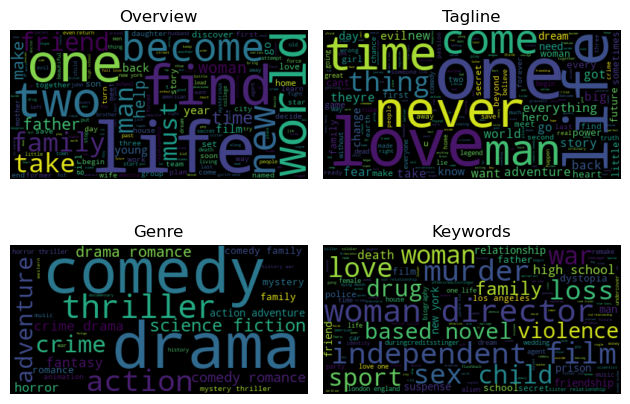

In [44]:
#plot wordcloud for preprocessed text(wihtout TF-IDF)
plt.subplots(nrows=2, ncols=2)
plt.subplot(2, 2, 1)
plt.imshow(wordcloud_overview, interpolation = 'bilinear')
plt.axis("off")
plt.title("Overview")

plt.subplot(2, 2, 2)
plt.imshow(wordcloud_tagline, interpolation = 'bilinear')
plt.axis("off")
plt.title("Tagline")

plt.subplot(2, 2, 3)
plt.imshow(wordcloud_genre_text, interpolation = 'bilinear')
plt.axis("off")
plt.title("Genre")

plt.subplot(2, 2, 4)
plt.imshow(wordcloud_keywords_text, interpolation = 'bilinear')
plt.axis("off")
plt.title("Keywords")


plt.tight_layout()
plt.show()

In [45]:
def frequency(TF_IDF_array, dictionary):
    frequency_dict = {}
    for i in range(0, len(dictionary)):
        frequency_dict[dictionary[i]] = np.sum(TF_IDF_array[:,i])
    return frequency_dict

In [46]:
#create dict with frequency of TF-IDF
overviewFrequency = frequency(TF_IDF_overview, overviewDict)
taglineFrequency = frequency(TF_IDF_tagline, taglineDict)
genreFrequency = frequency(TF_IDF_genres, genresDict)
keywordsFrequency = frequency(TF_IDF_keywords, keywordsDict)

In [47]:
#create wordclouds for TF-IDF
overviewWordcloud = WordCloud().generate_from_frequencies(frequencies = overviewFrequency)
taglineWordcloud = WordCloud().generate_from_frequencies(frequencies = taglineFrequency)
genreWordcloud = WordCloud().generate_from_frequencies(frequencies = genreFrequency)
keywordsWordcloud = WordCloud().generate_from_frequencies(frequencies = keywordsFrequency)

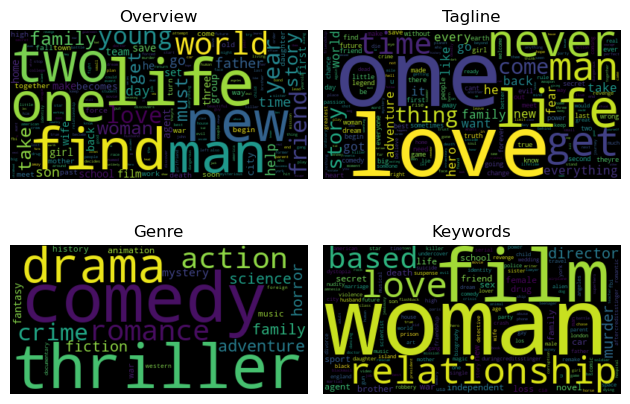

In [48]:
#plot wordcloud for preprocessed text(with frequency as weight based on TF-IDF)
plt.subplots(nrows=2, ncols=2)
plt.subplot(2, 2, 1)
plt.imshow(overviewWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Overview")

plt.subplot(2, 2, 2)
plt.imshow(taglineWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Tagline")

plt.subplot(2, 2, 3)
plt.imshow(genreWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Genre")

plt.subplot(2, 2, 4)
plt.imshow(keywordsWordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title("Keywords")

plt.tight_layout()
plt.show()

In [49]:
def getImportantWords(tf_idf, corpus, dictionary): #find 10 most important words based on TF-IDF
    important_words = []
    for d in range(0,len(corpus)):
        index_largest = tf_idf[d,:].argsort()[-10:]
        important_words.append([dictionary[i] for i in index_largest])
        
    return important_words

In [50]:
#get 10 most important words for each movie
importantWords_overview = getImportantWords(TF_IDF_overview, overviewCorpus, overviewDict)
importantWords_tagline = getImportantWords(TF_IDF_tagline, taglineCorpus, taglineDict)
importantWords_genre = getImportantWords(TF_IDF_genres, genresCorpus, genresDict)
importantWords_keywords = getImportantWords(TF_IDF_keywords, keywordsCorpus, keywordsDict)

In [64]:
#create corpus from important words
#overviewCorpus_importantW =  [overviewDict.doc2bow(text) for text in importantWords_overview]
#taglineCorpus_importantW =  [taglineDict.doc2bow(text) for text in importantWords_tagline]
#genreCorpus_importantW =  [genresDict.doc2bow(text) for text in importantWords_genre]
#keywordsCorpus_importantW =  [keywordsDict.doc2bow(text) for text in importantWords_keywords]

## **LDA**
Now for the actual topic modeling. We tried to do topic modeling with all words from the preprocessing and with the 10 most important words based on TF-IDF. As already mentioned we chose to use word from TF-IDF to find topics. Furthermore, we tried to do topic modeling with genres, tagline, overview and keywords, but ended up using only overview and keywords. The reason for not performing topic modeling on genre is that a genres is already topics movies are grouped into. Therefore we chose to use the genres in the beginning of the recommender system instead. 
The reason for not performing topic modeling on the tagline is that it didn't really explaing much about the movies, so we didn't think it was a good attribute to base a recommendation on. 


The topic modeling is performed using Latent Dirichlet Allocation(LDA). The implementation is performed with inspiration from [this](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) article. To perform LDA, we need to know the number of topics. There are different ways to investigate this, but here we have chosen to try different number of topics, and check how the topics look, and how it looks when plotted. Besides that, we don't want only a few movies in the same topic, because we want to find movies within the same topics, as a movie the user liked. But before recommending movies, we want to find similar users, and base our final recommendation on which movies the similar users liked. Therefore, we need a certain amount of movies in each topic, otherwise we won't have any movies left to recommend. The topic modeling is performed on overview if there are at least 40 movies left to recommend. We want there to be 20 movies in each topic on average, so this is how the number of topics are chosen for topic modeling on overview. 
After that, we do topic modeling on keywords if there are at least 20  movies left. We want there to 10 movies in each topic on average, so this is how the number of topics are chosen for topic modeling on keywords. 

In [51]:
def LDA(n_topics, corpus, dictionary): #create function for LDA
    lda = gensim.models.LdaMulticore(corpus = corpus,
                                       id2word=dictionary,
                                       num_topics=n_topics, 
                                     random_state= 5)
    return lda

In [52]:
def LDA_plot(path, lda_model, corpus, dictionary, n_topics): #function for plotting topics
    #Visualize topics
    pyLDAvis.enable_notebook()
    LDAvis_data_filepath = os.path.join(path + str(n_topics))
    
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
            
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f)
        
    pyLDAvis.save_html(LDAvis_prepared, path+ str(n_topics) +'.html')
    
    return LDAvis_prepared 

In [53]:
def assignTopic(lda, text, corpus): #assign topic with highest score
    assignedTopic = []
    for t in lda[corpus]: #loop through topics
        topic = []
        score = []
        for i in t:
            topic.append(i[0])
            score.append(i[1])
        assignedTopic.append(topic[np.argmax(score)]) #assign topic with highest score
    return assignedTopic

In [297]:
def TopicModeling_preprocessing(df, column):
    #create preProcess df
    df[column] = preProcess(df, column)
    
    #create dictionary, corpus and text for overview from preprocessed data
    colText = createDocs(df, column)
    colDict, colCorpus = getDictCorpus(colText)
    
    #TF-IDF
    TF_IDF = tf_idf(colCorpus, colDict, colText)
   
    #10 most important words - get text
    text = getImportantWords(TF_IDF, colCorpus, colDict)
    #dict and corpus for 10 most important words
    dictionary, corpus = getDictCorpus(text)
    
    return dictionary, corpus, text

In [ ]:
#the reason we do topic modeling for overview first, is because we believe that tells more about the movie than keywords

In [ ]:
#find movies where both topics are the same.
#If there are none, find result for only overview

In [461]:
def TopicModeling(df, movieTitle):
    if len(df) >= 20: #do topic modeling
        # get dictionary, corpus and text, 10 most important words
        OverviewDict, OverviewCorpus, OverviewText = TopicModeling_preprocessing(df, 'overview')
        KeywordsDict, KeywordsCorpus, KeywordsText = TopicModeling_preprocessing(df, 'keywords')
        n_topics = int(np.floor(len(df)/10)) #number of topics is assigned such that there on average is 10 movies per topic for overview
        
        #create LDA
        overviewLDA = LDA(n_topics, overviewCorpus, overviewDict)
        keywordsLDA = LDA(n_topics, keywordsCorpus, keywordsDict)
    
        #get columns for topics
        overviewTopic = assignTopic(overviewLDA, overviewText, overviewCorpus) 
        keywordsTopic = assignTopic(keywordsLDA, keywordsText, keywordsCorpus) 
        #add overview topic to df
        df['overview_topic'] = overviewTopic 
        df['keywords_topic'] = keywordsTopic 
        
        #Topicsfor the seen movie
        movie_overviewTopic = df[df.title == movieTitle].overview_topic.iloc[0]
        movie_keywordsTopic = df[df.title == movieTitle].keywords_topic.iloc[0]
        
        return df, movie_overviewTopic, movie_keywordsTopic
    
        #find movies where they have same overview topic and keywords topic as seen movie
        TP_recommend = df[(df.overview_topic == movie_overviewTopic) & (df.keywords_topic == movie_keywordsTopic)]
        if len(TP_recommend) == 0: #if there were no movies, use only overview Topic 
            TP_recommend = df[df.overview_topic == movie_overviewTopic]
            
    else:
        TP_recommend = df
    
    recommendedMovies = TP_recommend[TP_recommend.title != movieTitle] #remove seen movie
    
    #return recommendedMovies

In [462]:
d, OT, KT = TopicModeling(df_tmdb, 'Tangled')

In [466]:
d[d.overview_topic == 59]

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,overview_topic,keywords_topic
0,6,260000000,animation family,http://disney.go.com/disneypictures/tangled/,38757,hostage magic horse fairy tale musical princes...,en,Tangled,kingdom wantedand charmingbandit flynn rider h...,48.681969,...,591794936,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,theyre taking adventure new length,Tangled,7.4,3330,59,53
62,363,100000000,drama science fiction adventure,NaN,644,artificial intelligence prophecy prostitute an...,en,A.I. Artificial Intelligence,robotic boy first programmed love david adopte...,34.035114,...,235926552,146.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,david year old weighs pound foot inch tall bro...,A.I. Artificial Intelligence,6.8,1974,59,54
75,393,85000000,comedy family,NaN,10481,london england prison release prison woman pri...,en,102 Dalmatians,get ready howling good time new assortment irr...,9.895061,...,183611771,100.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,meet two unlikely hero bone pick,102 Dalmatians,5.1,313,59,7
109,527,53000000,comedy crime,NaN,4551,baseball bat widow recording contract recordin...,en,Be Cool,disenchanted movie industry chili palmer try m...,18.614720,...,95226116,118.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,everyone looking next big hit,Be Cool,5.4,292,59,29
159,714,65000000,drama crime thriller,NaN,1538,california taxi assassin hostage taxi driver f...,en,Collateral,cab driver max pick man offer drive around pro...,44.815022,...,217764291,120.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}, ...",Released,started like night,Collateral,7.0,1451,59,42
171,756,60000000,crime comedy romance,NaN,11775,california assassin infidelity fetish hitman t...,en,Intolerable Cruelty,revengeseeking gold digger marries womanizing ...,22.620125,...,119940815,100.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,cant keep hand others asset,Intolerable Cruelty,5.8,391,59,1
233,1043,45000000,comedy crime action,NaN,1493,undercover agent beauty contest terrorism,en,Miss Congeniality,local fbi office receives letter terrorist kno...,32.624355,...,212000000,111.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,never mess agent dress,Miss Congeniality,6.1,961,59,52
729,4373,0,drama romance,http://www.sonyclassics.com/alltherealgirls/,13132,southern usa small town virgin independent fil...,en,All the Real Girls,small north carolina town paul womanizer meet ...,3.659240,...,0,108.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,love puzzle piece,All the Real Girls,5.9,30,59,40
738,4523,46000,drama,NaN,14757,independent film,ps,Osama,teenage girl osama cut hair dress like boy get...,1.447734,...,0,83.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,save family girl must become boy,Osama,6.3,32,59,40


In [464]:
OT

59

In [465]:
KT

53

---

# **Selecting similar users (under Book chapter 9.3/Normalizing ratings and Example 9.9)**

---

In [481]:
def similarUsers(userID, nCommonMovies):
    #Assembling utility matrix, where row represent users (by User_ID), columns are movies (by Movie_ID), and the values are the ratings given to that movie by that user
    uti_mx = df_ratings.pivot_table(values='Rating', index='User_ID', columns='Movie_ID', aggfunc='first')
    #Normalize utility matrix, subtracting mean of ratings from the actual ratings for each respective user
    norm_uti_mx = uti_mx.sub(uti_mx.mean(axis=1), axis=0)
    
    #Calculating Cosine distance of a highlighted user and every other user if they have at least 'n_common_movies' that they both rated
    #Number of common movies needed to be considering other user
    
    #init matrix
    cosine_dist_mx = pd.DataFrame(index=[userID], columns=norm_uti_mx.index)
    cosine_dist_mx = cosine_dist_mx.drop(userID, axis=1)
    
    chosen_set = set(norm_uti_mx.loc[userID,:].dropna().index)
    
    for user in cosine_dist_mx.columns:
        # list of common movie IDs
        common_list = list(chosen_set & set(norm_uti_mx.loc[user,:].dropna().index))
        if len(common_list) > nCommonMovies:
            a = norm_uti_mx.loc[userID, common_list].values
            b = norm_uti_mx.loc[user, common_list].values
            cosine_dist_mx[user] = distance.cosine(a,b)
            
    # sort by distance, lower distance means more similar
    cosine_dist_mx_sorted = cosine_dist_mx.sort_values(userID, axis=1).dropna(axis=1)
    similarity = cosine_dist_mx_sorted.T
    

    mostSimilarUsers = similarity[similarity[userID] == 0][userID].keys().to_list() #find users with similarity on 0 
    if not mostSimilarUsers: #if no users has similarity on 0
        mostSimilarUsers = similarity[userID].nsmallest(10).keys().to_list() #userID for 10 most similar users
    
    return mostSimilarUsers

In [482]:
userID = 6
userSimilarity = similarUsers(userID, 20)

/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv

In [506]:
#this find the recommendedMovies 
userSimilarity = similarUsers(userID, 20)
users = df_ratings[df_ratings.User_ID.isin(userSimilarity)]
#

#recommendedMovies_ID = df_ratings[df_ratings.User_ID.isin(userSimilarity)].groupby('Movie_ID').mean().Rating.nlargest(5).keys().to_list()
#recommendedMovies_titles = df_movies[df_movies.Movie_ID.isin(recommendedMovies_ID)].Name.to_list()

/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)
/opt/anaconda3/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv

,User_ID,Rating,Movie_ID
70115,2045508,5,30
70375,1626224,5,30
71547,1007967,5,30
71629,1511683,1,30
75187,2170930,1,30
...,...,...,...
17322784,1488235,5,4492
17323102,526856,5,4492
17323118,1806932,5,4492
17323790,794999,5,4492


In [500]:
#we still need to be able to run userSimilarity with a movie df

[148, 225, 256, 362, 378]

In [ ]:
#userSimilarity
#use group by, movieID and raitng, and count mean

---
# **Recommendation**
---

The way the recommendation system works is by first checking if the user is new. If it is, the system recommends the 5 most popular movies, since the system don't have any data on the user yet. 
If the user is a exsisting user, it checks if the user liked the just seen movie. If the user did like it, it removes all movies from our movie database that the user already saw, except for the one just seen, since we need information about that movie later. The movies that are left now, is now filtered by genre. All movies with same genre as the just seen movies, are found. There are often several genres, but they just need to have one in common to be kept in the database. Now, the community for the just seen movie is found. Then, all movies left in the database, that is in the same community, is found. Then topic modeling is performed, and lastly similar users are found. Based on these, the 5 movies left with higest average score is found, and recommended. 

If the user didn't like the movie just seen, we are looking for the movie they have seen with higest score. Often there will be several movies with same rating. We would like to take the one seen latest, but since we don't have time of watching the movies, we are taking the first element with higest rating. If this rating is 3 or greater ...

In [ ]:
#1A: call recommendation(userID, movieTitle, df_ratings, df_movies, df_tmdb)
#1B: call recommendation(None, None, None, df_ratings, df_movies, df_tmdb)

In [386]:
def recommendation(userID, rating, movieTitle, rating_df, movie_df, TMDB_movies): #if userID is None, it is a new user
    if userID == None: #if new user
        #find 5 most popular movies
        mostPopular_index = TMDB_movies.popularity.nlargest(5).index.to_list() #index of 5 most popular movies(of given day)
        mostPopularMovies = TMDB_movies.iloc[mostPopular_index].title.to_list() #list of 5 most popular movies(of given day)
        recommendedMovies = mostPopularMovies  #recommend most popular movies

        
    else: #if existsting user
        userRatings = rating_df[rating_df.User_ID == userID] #rating from user
        movieID = movie_df[movie_df.Name == movieTitle].Movie_ID.iloc[0] #ID for seen movie
        #rating = userRatings[userRatings.Movie_ID == movieID].Rating.iloc[0]  #rating for seen movie
        seenMovies_ID = userRatings.Movie_ID.to_list() #list of ID of movies already seen by user
        seenMovies_titles = df_movies[df_movies.Movie_ID.isin(seenMovies_ID)].Name.to_list() #list of titles of movies already seen by user
        
        
        if rating >= 3: #if user liked the movie
            seenMovies_titles.remove(movieTitle) #remove movieTitle from list of seen movies, since we still need that
            movies = TMDB_movies[~TMDB_movies.title.isin(seenMovies_titles)] #remove movies already seen(except the one just seen)
            genreFiltering = filterByGenre(movieTitle, movies) #find movies with same genre as movieTitle
            communityMovies = get_movie_community_df(movieTitle, genreFiltering) #find movies within same community
            TP_movies = TopicModeling(communityMovies, movieTitle) #perform topic modeling, and return movies left after that
           
        userSimilarity = similarUsers(user_ID, 20)
        users = df_ratings[df_ratings.User_ID.isin(userSimilarity)]
        #now remove movies that are in seen_Movies ID
        
            recommendedMovies = TP_movies[0:5]
            
        
        else: #if user didn't like the movie
            bestRating = userRatings.Rating.max() #max rating

            if bestRating >= 3: #if the user like movie with higest rating
                bestRating_index = userRatings.Rating.argmax() #index of best rating
                bestRating_movieID = userRatings.iloc[bestRating_index].Movie_ID #movieID of movie with best rating
                bestMovie_title = movie_df[movie_df.Movie_ID == bestRating_movieID].Name #title of best rated movie
                
                seenMovies_titles.remove(bestMovie_title) #remove bestMovie_title from list of seen movies, since we still need that
                movies = TMDB_movies[~TMDB_movies.title.isin(seenMovies_titles)] #remove movies already 
                genreFiltering = filterByGenre(bestMovie_title, movies) #find movies with same genre as movieTitle
                communityMovies = get_movie_community_df(bestMovie_title, genreFiltering) #find movies within same community
                TP_movies = TopicModeling(communityMovies, bestMovie_title) #perform topic modeling, and return movies left after that
                #now look at similar users
                
                recommendedovies = TP_movies[0:5]
                
            else: #if the user didn't like any movies seen
                #find similar users, and recommend movies with higest average, that isn't already seen
                
                recommendedMovies = 0
             
    if not reccoendedMovies:
        print("There are no recommendations for movies, that you haven't already seen")
    return recommendedMovies

In [387]:
movieTitle = "50 First Dates"
movie_db = recommendation(1351377, movieTitle, df_ratings, df_movies, df_tmdb)

No topic modeling on overview


In [ ]:
#show exaple with plot and print

In [ ]:
keywordsLDA_plot = LDA_plot('results/ldavis_prepared_', keywordsLDA, corpus, dictionary, n_topics_overview) #create plot

In [ ]:
#example
  # Print the Keyword in the 10 topics for overview
        #print("Topic for community within overview")
        #pprint(overviewLDA.print_topics())
        
        
    #create plots
    overviewLDA_plot = LDA_plot('results/ldavis_prepared_', overviewLDA, corpus, dictionary, n_topics_overview) 
        
      